In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import time
import requests
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from google.colab import files
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

pd.set_option('display.max_columns', None)

from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/MyDrive/'

Mounted at /content/gdrive


## Modeling with selected features

In [ ]:
df = pd.read_csv(path + './ph_fires_matched_2.1.csv')
df = df[
    (df.building_type_code_es == 1)
]
df = df.drop(['objectid', 'corrected_address', 'corrected_unit', 'std_city', 'std_st', 'std_zip5'], axis=1)

# Remove imputed development-level and public housing agency-level columns.
df = df[[x for x in df.columns if 'pha_' not in x and 'dev_' not in x]]

In [ ]:
start_year = 2012
stop_year = 2019

for col in [f'building_fires_{stop_year + 2}', f'building_fires_{stop_year + 1}']:
  df[col] = df[col] > 0

# df[f'det_alert_{start_year}_{stop_year}'] = df[[f'det_alert_{year}' for year in range(start_year, stop_year + 1)]].sum(axis=1)
# df[f'aes_pres_{start_year}_{stop_year}'] = df[[f'aes_pres_{year}' for year in range(start_year, stop_year + 1)]].sum(axis=1)
df[f'sum_flame_sprd_{start_year}_{stop_year}'] = df[[f'flame_sprd_{year}' for year in range(start_year, stop_year + 1)]].sum(axis=1)
df[f'sum_building_fires_{start_year}_{stop_year}'] = df[[f'building_fires_{year}' for year in range(start_year, stop_year + 1)]].sum(axis=1)
df[f'sum_unconfined_{start_year}_{stop_year}'] = df[[f'inc_type_111_{year}' for year in range(start_year, stop_year + 1)]].sum(axis=1)
# df[f'sum_money_lost_{start_year}_{stop_year}'] = df[[f'prop_loss_{year}' for year in range(start_year, stop_year + 1)]].sum(axis=1) + df[[f'cont_loss_{year}' for year in range(start_year, stop_year_plus_one)]].sum(axis=1)


selected_features = [
    # Past fire data
    f'building_fires_{stop_year + 1}',
    f'building_fires_{stop_year + 2}',

    # f'sum_flame_sprd_{start_year}_{stop_year}',
    f'sum_building_fires_{start_year}_{stop_year}',
    # f'sum_unconfined_{start_year}_{stop_year}',

    # Income/poverty
    # 'rent_per_month',
    # 'hh_income',
    'pct_median',
    'pct_welfare_major',
    'pct_wage_major',
    'pct_other_major',
    # 'person_income',

    # Other building characteristics
    'people_total',
    'construction_year',
    'total_units',

    # Age
    'pct_age25_50',
    'pct_age51_61',
    'pct_age62plus',
    'pct_age85plus',
    # 'eldly_prcnt',

    # Children
    'pct_2adults',
    'pct_1adult',
    'chldrn_mbr_cnt',

    # Disability status
    'pct_disabled_all',
    # 'pct_disabled_ge62',
    # 'pct_disabled_lt62',
    # 'pct_disabled_lt62_all',

    # Number of beds per unit
    'pct_bed1',
    'pct_bed2',
    'pct_bed3',
    'pct_overhoused',
]

selected_df = df[selected_features]
print(selected_df.shape)

(4021, 22)


<ipython-input-3-112badbc03d6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col] > 0
<ipython-input-3-112badbc03d6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'sum_flame_sprd_{start_year}_{stop_year}'] = df[[f'flame_sprd_{year}' for year in range(start_year, stop_year + 1)]].sum(axis=1)
<ipython-input-3-112badbc03d6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [ ]:
train_cols = [x for x in selected_df.columns if f'{stop_year + 1}' in x]
test_cols = [x for x in selected_df.columns if f'{stop_year + 2}' in x]

# Remove all 2021 and 2020 data
X_train = selected_df.drop(test_cols + train_cols, axis=1)
X_train = X_train.fillna(X_train.mean())

display(X_train.sample())

# Train on 2020 fires with supervised learning
y_train = selected_df[f'building_fires_{stop_year + 1}']

# Reserve 2021 as validation
y_test = selected_df[f'building_fires_{stop_year + 2}']

# X_train_scaled = StandardScaler().fit_transform(X_train)
X_train_scaled = X_train
# X_train_resampled, y_train_resampled = SMOTE(random_state=538).fit_resample(X_train_scaled, y_train)
X_train_resampled = X_train_scaled
y_train_resampled = y_train

print(len(X_train_resampled))

param_grid = {
    'criterion': ['gini'],
    'splitter': ['best'],
    'max_depth': [3, 4, 5, 15],
    'min_samples_split': [2, 3, 6, .01, .05, .01],
    'min_samples_leaf': [1, 2, 5, .0001, .01, .05],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}, {0: 1, 1: 7}, {0: 1, 1: 15}]
}

custom_f1_scorer = make_scorer(f1_score, pos_label=True)

tree = DecisionTreeClassifier()
grid_search = GridSearchCV(tree, param_grid, scoring=custom_f1_scorer, n_jobs=-1, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)
model = grid_search.best_estimator_
print(grid_search.best_params_)

,sum_building_fires_2012_2019,pct_median,pct_welfare_major,pct_wage_major,pct_other_major,people_total,construction_year,total_units,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_2adults,pct_1adult,chldrn_mbr_cnt,pct_disabled_all,pct_bed1,pct_bed2,pct_bed3,pct_overhoused
18309,6.0,20.860001,0.0,7.53,92.470001,97.0,1973.0,100,0.0,25.809999,74.190002,0.0,0.0,0.0,0.0,44.330002,100.0,0.0,0.0,0.0


4021
{'class_weight': {0: 1, 1: 2}, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 0.05, 'min_samples_split': 2, 'splitter': 'best'}


In [ ]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(model, out_file=None,
                           feature_names=X_train_resampled.columns,
                           class_names=['No Fires', 'Yes Fires'],
                           filled=True, rounded=True, special_characters=True)

dot_data = dot_data.replace('shape=box', 'shape=box, width=0.3, height=0.3')
graph = graphviz.Source(dot_data)
graph.view()

from datetime import datetime
now = datetime.now()
print(now)
graph.render(f'tree_plot_{now}')

2023-08-15 22:20:32.664433


'tree_plot_2023-08-15 22:20:32.664433.pdf'

In [ ]:
y_pred = model.predict(X_train_scaled)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.93      0.91      0.92      3610
        True       0.32      0.36      0.34       411

    accuracy                           0.86      4021
   macro avg       0.62      0.64      0.63      4021
weighted avg       0.86      0.86      0.86      4021



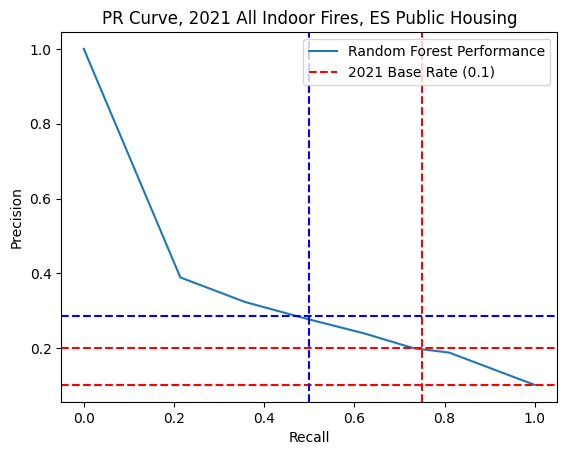

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_scores = model.predict_proba(X_train_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision, label="Random Forest Performance")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve, 2021 All Indoor Fires, ES Public Housing")
base_rate = len(df[df.building_fires_2021 == True]) / len(df)
plt.axhline(base_rate, color='r', linestyle='--', label=f'2021 Base Rate ({round(base_rate, 2)})')
plt.axhline(.2, color='r', linestyle='--')
plt.axvline(.75, color='r', linestyle='--')
plt.axvline(.5, color='b', linestyle='--')
plt.axhline((2/7), color='b', linestyle='--')

plt.legend()
plt.show()


In [ ]:
feature_names = X_train.columns
importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]}")


sum_building_fires_2012_2019: 0.943985095060107
pct_median: 0.0468941807624561
total_units: 0.009120724177436961
pct_bed3: 0.0
pct_welfare_major: 0.0
pct_wage_major: 0.0
pct_other_major: 0.0
people_total: 0.0
construction_year: 0.0
pct_age25_50: 0.0
pct_overhoused: 0.0
pct_age62plus: 0.0
pct_age85plus: 0.0
pct_2adults: 0.0
pct_1adult: 0.0
chldrn_mbr_cnt: 0.0
pct_disabled_all: 0.0
pct_bed1: 0.0
pct_bed2: 0.0
pct_age51_61: 0.0


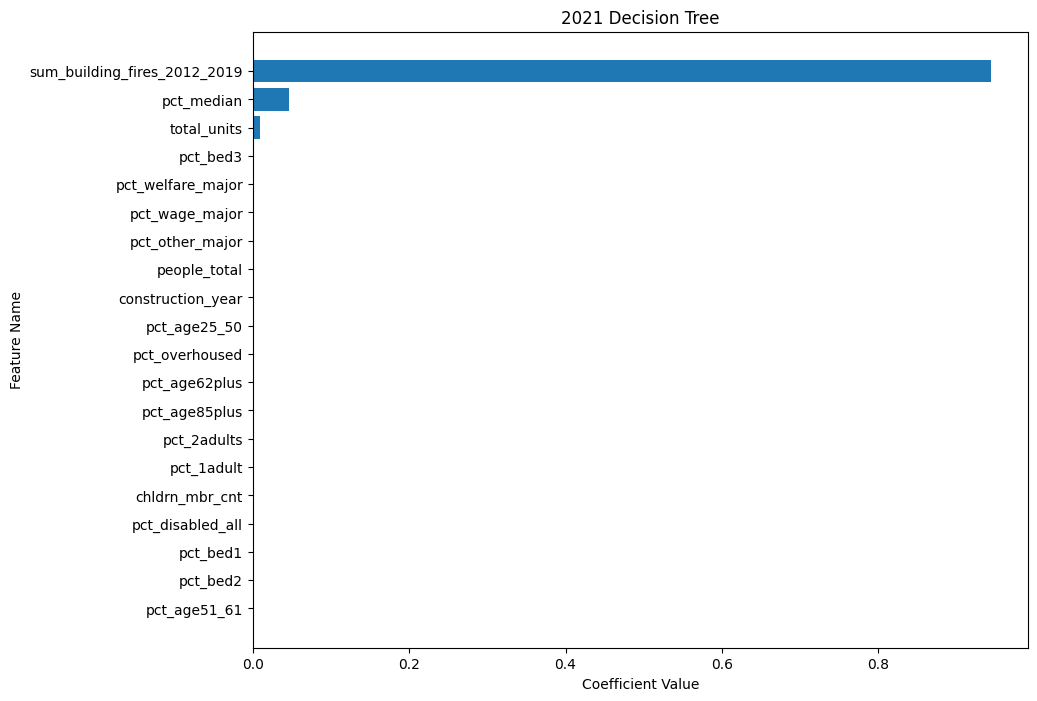

In [ ]:
features = [feature_names[i] for i in sorted_indices[:50]]
coeffs = [importances[i] for i in sorted_indices[:50]]
plt.figure(figsize=(10, len(features) * 0.4))
plt.barh(features, coeffs)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('2021 Decision Tree')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
probabilities = model.predict_proba(X_train_scaled)
fire_probabilities = probabilities[:, 1]

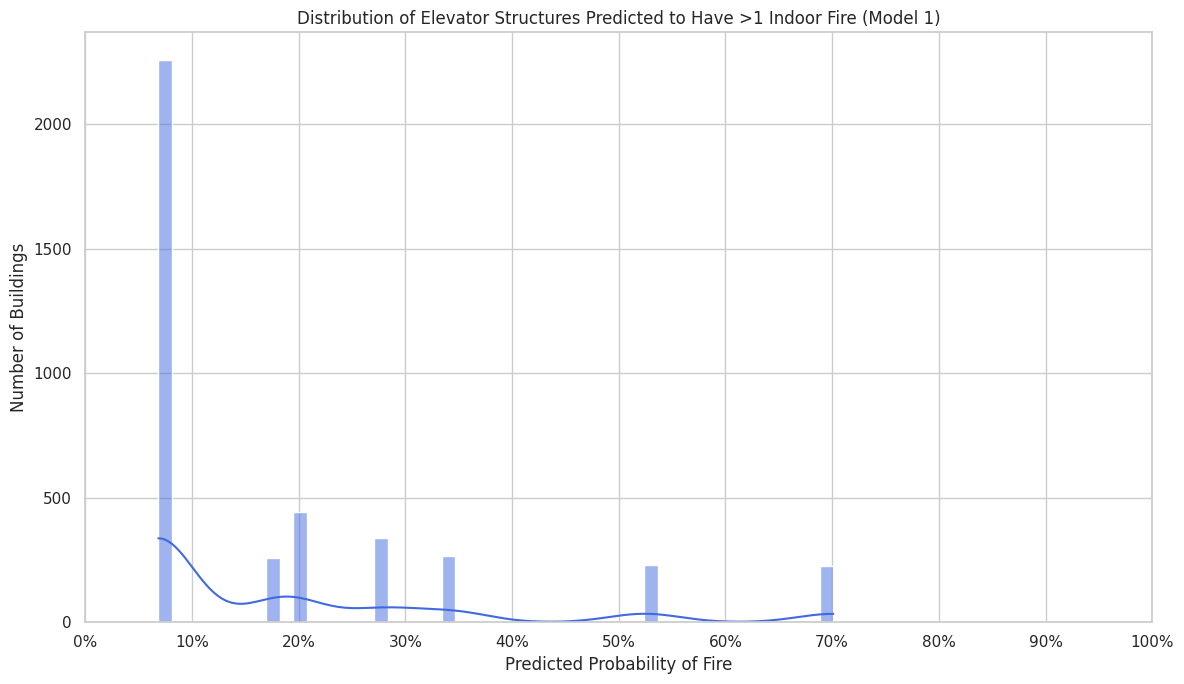

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 7))
sns.histplot(fire_probabilities, bins=50, color='royalblue', kde=True, edgecolor='w')
plt.xlabel('Predicted Probability of Fire')
plt.ylabel('Number of Buildings')
plt.title('Distribution of Elevator Structures Predicted to Have >1 Indoor Fire (Model 1)')
plt.xticks(ticks=[i/100 for i in range(0, 101, 10)], labels=[f'{i}%' for i in range(0, 101, 10)])
plt.tight_layout()
plt.show()


In [ ]:
# df_display = pd.read_csv(path + './ph_fires_matched_2.1.csv')

# df_display = df_display[
#     (df_display.building_type_code_es == 1)
# ]

# df_display['fire_probability'] = fire_probabilities
# df_display.to_csv('lr_es_type1_probs.csv', index=False)
# files.download('lr_es_type1_probs.csv')

In [ ]:
# df_display.fire_probability.describe()